In [ ]:
import os
import re
import cv2
import time
import shutil
import zipfile
import urllib.request
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
from shutil import rmtree
#rmtree("train") #Carpeta
os.remove("soil_photos.zip") #Archivos

In [ ]:
# download soil_photos.zip
file = 'soil_photos.zip'
url = 'http://apmonitor.com/pds/uploads/Main/'+file
urllib.request.urlretrieve(url, file)

('soil_photos.zip', <http.client.HTTPMessage at 0x7f47c1473460>)

In [ ]:
# extract archive soil_photos.zip
with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
os.remove(file)

In [ ]:
training_data_directory = 'train'
test_data_directory = 'test'

In [ ]:
# Initiate data processing tools
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

# Load data into Python
training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 75 images belonging to 5 classes.
Found 17 images belonging to 5 classes.


In [ ]:
# choose model parameters
num_conv_layers = 2
num_dense_layers = 1
layer_size = 32
num_training_epochs = 20
MODEL_NAME = 'soil'

In [ ]:
for _ in range(num_dense_layers):
  print(_)

0


In [ ]:
# Initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convolutional layer
model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3), padding="SAME"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(layer_size, (2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# add output layer
model.add(Dense(3)) #Carpetas
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

# use the data already loaded previously to train/tune the model
model.fit(training_data,
            epochs=num_training_epochs,
            validation_data = testing_data)

# save the trained model
model.save(f'{MODEL_NAME}.h5')

Epoch 1/10
3/3 [==============================] - 6s 2s/step - loss: 2.0612 - accuracy: 0.2667 - val_loss: 1.3934 - val_accuracy: 0.3529
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 1.4120 - accuracy: 0.3333 - val_loss: 1.2851 - val_accuracy: 0.3529
Epoch 3/10
3/3 [==============================] - 5s 2s/step - loss: 1.1922 - accuracy: 0.3600 - val_loss: 0.9900 - val_accuracy: 0.5294
Epoch 4/10
3/3 [==============================] - 5s 1s/step - loss: 0.9041 - accuracy: 0.6267 - val_loss: 1.0654 - val_accuracy: 0.6471
Epoch 5/10
3/3 [==============================] - 5s 1s/step - loss: 1.2749 - accuracy: 0.4000 - val_loss: 1.0301 - val_accuracy: 0.5294
Epoch 6/10
3/3 [==============================] - 6s 2s/step - loss: 0.7742 - accuracy: 0.6000 - val_loss: 1.0116 - val_accuracy: 0.4706
Epoch 7/10
3/3 [==============================] - 5s 1s/step - loss: 0.7790 - accuracy: 0.6800 - val_loss: 0.9476 - val_accuracy: 0.4118
Epoch 8/10
3/3 [=========================

In [ ]:
weights = model.get_weights()
for i in weights:
    print (i.shape)

model.summary()

(3, 3, 3, 32)
(32,)
(3, 3, 32, 32)
(32,)
(2, 2, 32, 32)
(32,)
(123008, 32)
(32,)
(32, 5)
(5,)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_42 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 activation_43 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_27 (MaxPool

In [ ]:
def make_prediction(image_fp):
    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2,1,0]])
    img = image.load_img(image_fp, target_size = (256,256))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)

    class_ = ["Gravel", "Sand", "Silt"] # possible output values
    predicted_value = class_[model.predict(img_batch).argmax()]
    true_value = re.search(r'(Gravel)|(Sand)|(Silt)', image_fp)[0]

    out = f"""Predicted Soil Type: {predicted_value}
    True Soil Type: {true_value}
    Correct?: {predicted_value == true_value}"""

    return out

1/1 [==============================] - 0s 35ms/step
Predicted Soil Type: Silt
    True Soil Type: Sand
    Correct?: False


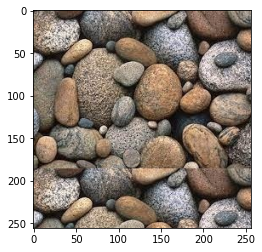

In [ ]:
test_image_filepath = test_data_directory + r'/Sand/7.jpg'
print(make_prediction(test_image_filepath))

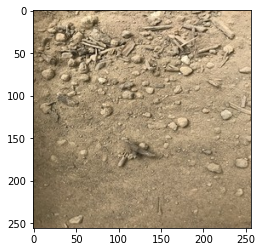

In [ ]:
percentage_photo = test_data_directory + r"/Silt/5.jpg"
im = cv2.imread(percentage_photo) # load image
plt.imshow(im[:,:,[2,1,0]])

In [ ]:
def split_images(image_dir, save_dir):
    classification_list = ['Gravel', 'Sand', 'Silt']
    for classification in classification_list:
        folder = image_dir + '/' + classification + '/'
        save_folder = save_dir + '/' + classification + '/'
        files = [f for f in listdir(folder) if isfile(join(folder, f))]

        for file in files:
            if '.ini' in file:
                continue
            fp = folder + file
            img = cv2.imread(fp)
            h,w,c = img.shape
            im_dim = 64
            # For cropping images
            for r in range(0,img.shape[0],im_dim):
                for c in range(0,img.shape[1],im_dim):
                    cropped_img = img[r:r+im_dim, c:c+im_dim,:]
                    ch, cw, cc = cropped_img.shape
                    if ch == im_dim and cw == im_dim:
                        write_path = f"{save_folder + str(randrange(100000))}img{r}_{c}.jpg"
                        cv2.imwrite(write_path,cropped_img)
                    else:
                        pass

In [ ]:
try:
    parent = training_data_directory.replace('train', '')
    dirs = ['train_divided', 'test_divided']
    class_ = ["Gravel", "Sand", "Silt"]
    for dir in dirs:
        os.mkdir(os.path.join(parent, dir))
        for classification in class_:
            os.mkdir(os.path.join(parent, dir, classification))

    # split training images
    split_images(image_dir=training_data_directory,
                save_dir=training_data_directory.replace('train', 'train_divided'))
    # split test images
    split_images(image_dir=test_data_directory,
                save_dir=test_data_directory.replace('test', 'test_divided'))
except FileExistsError:
    pass

In [ ]:
model_fp = os.getcwd()+'/'+'soil.h5'
print(model_fp)
model = load_model(model_fp)

/content/soil.h5


In [ ]:
def classify_images(image_fp, model):
    classes = ['Gravel', 'Sand', 'Silt']
    gravel_count = 0
    sand_count = 0
    silt_count = 0

    img = cv2.imread(image_fp)
    img = cv2.resize(img,(1024,1024))
    im_dim = 256

    for r in range(0, img.shape[0], im_dim):
        for c in range(0, img.shape[1], im_dim):
            cropped_img = img[r:r + im_dim, c:c + im_dim, :]
            h, w, c = cropped_img.shape
            if h == im_dim and w == im_dim:
                classification = model_classify(cropped_img, model)
                if classification == classes[0]:
                    gravel_count += 1
                elif classification == classes[1]:
                    sand_count += 1
                elif classification == classes[2]:
                    silt_count += 1
            else:
                continue
    total_count = gravel_count + sand_count + silt_count
    proportion_array = [gravel_count / total_count, sand_count / total_count, silt_count / total_count]
    return proportion_array


def model_classify(cropped_img, model):
    classes = ['Gravel', 'Sand', 'Silt']
    image_array = cropped_img / 255.
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0]
    first_idx = np.argmax(prediction_array)
    first_class = classes[first_idx]
    return first_class

def classify_percentage(image_fp):
    start = time.time()
    out = classify_images(image_fp=image_fp, model=model)
    finish = str(round(time.time() - start, 5))

    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2, 1, 0]])

    print(f'''---
Percent Gravel: {round(out[0] * 100, 2)}%)
Percent Sand: {round(out[1] * 100, 2)}%)
Percent Silt: {round(out[2] * 100, 2)}%)
Time to Classify: {finish} seconds
---''')

In [ ]:
classify_percentage(image_fp=percentage_photo)